# Bonus1: Parallel Algorithms - Decentralized Optimization

### Name: Connor DePalma


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy as np
import threading # I attempted using Ray, but it doesn't seem to work well with my design

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = np.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.00328312 -0.21992185 -0.04358065  0.0322413  -0.0207484  -0.24306572
   0.09646102 -0.17374621]]
test std = 
[[1.06310634 1.01234093 0.89041948 0.94309033 0.94134724 1.01471169
  1.16819045 0.95856018]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 1.5 Create Class for Nodes 

In [5]:
class Node:
    def __init__(self, x, y, weight=None):
        
        self.p = x.shape[0]
        self.d = x.shape[1] # num features
        self.w = np.zeros((self.d,1))
        self.w_hist = []
        
        indices = np.random.permutation(self.p)
        self.x = x[indices,:]
        self.y = y[indices,:]
        
        self.weight = weight
        
        self.connections = []


    def connect_node(self, node):
        self.connections.append(node)
        
    def get_param_hist(self):
        return self.w_hist
        
    def get_param(self):
        return self.w
    
    def collect_neighbor(self):
        weight = None
        n_weight = None
        if self.weight == None:
            # all weights the same
            n_weight = 1.0 / (len(self.connections)+1) 
            weight = n_weight
        else:
            # use the weight value for main node
            # distribute the rest to neighbors
            # total weight should be 1.0
            weight = self.weight
            n_weight = (1.0 - weight)/len(self.connections)
        
        w = np.zeros((self.d,1))
        for node in self.connections:
            w = w + node.get_param()*n_weight            
        w = w + self.w*weight
        return w
            
      
    def gradient(self,lam):
        yx = numpy.multiply(self.y,self.x)
        yxw = numpy.dot(yx, self.w) 
        mat = -yx / (1 + numpy.exp(yxw)) 
        g = np.mean(mat, axis=0).reshape(self.d,1) 
        return g + lam*self.w
    
    
    def gd(self, l, lam, epochs):
        
        for i in range(epochs):
            grad = self.gradient(lam)
            w_collected = self.collect_neighbor()
            self.w = w_collected - l * grad
            # collect history of w for each Node
            # can get objective values for each epoch post-simulation
            # as described in the paper
            self.w_hist.append(self.w)
                

## 1.6 Create Function to Run Simulation 

In [6]:
def loss(x,y,w):
    yx = numpy.multiply(y,x)
    yxw = numpy.dot(yx, w)
    # calculate loss
    loss = numpy.log(1 + numpy.exp(-yxw)) 
    return np.mean(loss)


def Dec_Opt_Sim(x,y,l,lam,epochs,weight=None):
    
    num_nodes = 7
    
    nodes = []
    n,d = x_train.shape
    sections = n//num_nodes
    
    for i in range(num_nodes):
        node = Node(x_train[i*sections:(i+1)*sections,:],y_train[i*sections:(i+1)*sections,:], weight)
        nodes.append(node)
    
    # Make connections like picture in assignment
    # Connection go from left to right
    
    nodes[0].connect_node(nodes[1])
    nodes[0].connect_node(nodes[2])
    
    nodes[1].connect_node(nodes[0])
    nodes[1].connect_node(nodes[2])
    nodes[1].connect_node(nodes[3])
    
    nodes[2].connect_node(nodes[0])
    nodes[2].connect_node(nodes[1])
    nodes[2].connect_node(nodes[4])
    
    nodes[3].connect_node(nodes[1])
    nodes[3].connect_node(nodes[4])
        
    nodes[4].connect_node(nodes[2])
    nodes[4].connect_node(nodes[3])
    nodes[4].connect_node(nodes[5])
    nodes[4].connect_node(nodes[6])
    
    nodes[5].connect_node(nodes[4])
    nodes[5].connect_node(nodes[6])
    
    nodes[6].connect_node(nodes[4])
    nodes[6].connect_node(nodes[5])
    
    # Run Sim using Threading
    threads = []
    for node in nodes:
        thread = (threading.Thread(target=node.gd, args=(l,lam,epochs)))
        thread.start()
        threads.append(thread)
    
    for thread in threads:
        thread.join()
         
    # Collect results
    w = np.zeros((d,1))
    w_hist = np.zeros((d,epochs))

    
    for node in nodes:
        w += node.get_param()
        w_hist += np.array(node.get_param_hist())[:,:,0].T
        
    w /= num_nodes # Average final w value from each node
    w_hist /= num_nodes # Average w values from each node for at each epoch
    
    obj = []
    for i in range(epochs):
        l = loss(x_train,y_train,w_hist[:,i]) # get loss values at each epoch
        reg = lam/2 * np.dot(w_hist[:,i].T,w_hist[:,i]).item() # since I used regularized term for the gradients
        objval = l + reg
        obj.append(objval)
    
    return w, obj

## 1.7 Run Simulations 

In [7]:
l = 1E-1
lam = 1E-6
epochs = 250

w, obj = Dec_Opt_Sim(x_train,y_train,l,lam,epochs,weight=None)
w_weight, obj_weight = Dec_Opt_Sim(x_train,y_train,l,lam,epochs,weight=0.8)

## 1.8 Look at Results 

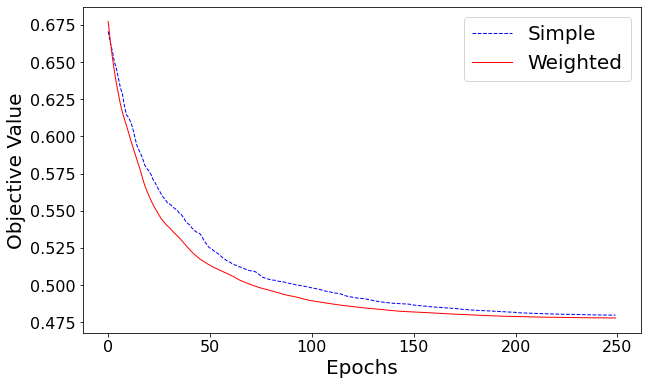

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 6))

epochs_range = range(epochs)

line0, = plt.plot(epochs_range, obj, '--b', linewidth=1)
line1, = plt.plot(epochs_range, obj_weight, '-r', linewidth=1)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['Simple', 'Weighted'], fontsize=20)
plt.show()

In [9]:
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [10]:
# evaluate test errors
f_test_w = predict(w_weight, x_test)
f_test_uw = predict(w, x_test)


diff_w = numpy.abs(f_test_w - y_test) / 2
diff_uw = numpy.abs(f_test_uw - y_test) / 2


error_test_w = numpy.mean(diff_w)
error_test_uw = numpy.mean(diff_uw)


print('testing classification error with weighting is ' + str(error_test_w))
print('testing classification error without weighting is ' + str(error_test_uw))

testing classification error with weighting is 0.2109375
testing classification error without weighting is 0.2109375
